<a href="https://colab.research.google.com/github/AguaClara/CEE4520/blob/master/Unit_Process_Designs/Sed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install aguaclara

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 215kB 14.5MB/s 
  Created wheel for aguaclara: filename=aguaclara-0.2.5-cp36-none-any.whl size=99513 sha256=a8f56d4ca2eef631cad9cf003b834687704887bce84e4bbb033d09cd342a0a13
  Stored in directory: /root/.cache/pip/wheels/1a/e0/5f/f5c42b11bb5d494c600792649ab0847fe9e4df3b8774d6f4c6
Successfully built aguaclara


In [2]:
import aguaclara as ac
from aguaclara.core.units import unit_registry as u
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Design of 

In [3]:
""" A sedimentation tank of an AguaClara water treatment plant
Example:
    >>> from aguaclara.design.sed_tank import *
    >>> sed_tank = SedimentationTank(q_tank = 6 * u.L / u.s)
    >>> sed_tank.diffuser_hl
    <Quantity(0.009259259259259259, 'centimeter')>
"""
from aguaclara.core.units import u
import aguaclara.core.constants as con
import aguaclara.core.materials as mat
import aguaclara.core.pipes as pipe
from aguaclara.core import drills
import aguaclara.core.utility as ut
from aguaclara.design.component import Component
import aguaclara.core.physchem as pc
import aguaclara.core.head_loss as hl

import numpy as np
import math


class SedimentationTank(Component):
    """Design an AguaClara plant's sedimentation tank.
    An sedimentation tank's design relies on the sedimentation channel's design
    in the same plant, but assumed/default values may be used to design an
    sedimentation tank by itself. To design these components in tandem, use
    :class:`aguaclara.design.sed.Sedimentor`.
    Constants:
        - ``MAN_Q_RATIO (float)``: The ratio of the first to last port flow in the
          manifold.
        - ``OUTLET_MAN_HL (float * u.cm)``: The headloss of the outlet manifold
        - ``JET_REVERSER_ND (float * u.inch)``: The nominal diameter of the jet
          reverser.
        - ``JET_REVERSER_TO_DIFFUSERS_H (float * u.cm)``: The height between
          the jet reverser and diffusers.
        - ``DIFFUSER_L (float * u.cm)``: The length of a diffuser.
    Design Inputs:
        - ``q_tank (float * u.L / u.s)``: Sed tank flow rate
          (recommended, defaults to max flow given 6 m pipe length constraint)
        - ``temp (float * u.degC)``: Water temperature (recommended, defaults to
          10°C)
        - ``vel_upflow (float * u.mm / u.s)``: Upflow velocity
          (optional, defaults to 1 mm/s)
        - ``l_inner (float * u.m)``: The inner length
          (optional, defaults to 5.8m)
        - ``w_inner (float * u.inch)``: The inner width
          (optional, defaults to 42in.)
        - ``jet_shear_max (float * u.Pa)``: The max shear after the jet reverser
           (optional, defaults to 0.5 Pa)
        - ``diffuser_sdr (int)``: The standard dimension ratio of a diffuser
          (optional, defaults to 26)
        - ``inlet_man_sdr (float)``: The standard dimension ratio of the inlet
          manifold (optional, defaults to 41)
        - ``jet_reverser_sdr (int)``: The standard dimension ratio of the jet
          reverser (optional, defaults to 26)
        - ``plate_settler_angle (float * u.deg)``: The angle of the plate
          settler (optional, defaults to 60°)
        - ``plate_settler_s (float * u.cm)``: Spacing in between plate settlers
          (optional, defaults to 2.5cm)
        - ``plate_settler_thickness (float * u.mm)``: Thickness of a plate
          settler (optional, defaults to 2mm)
        - ``plate_settler_cantilever_l_max (float * u.cm)``: The max length of
          the plate settler cantilever (optional, defaults to 20cm)
        - ``plate_settler_vel_capture (float * u.mm / u.s)``: The capture
          velocity of a plate settler (optional, defaults to 0.12mm/s)
        - ``outlet_man_orifice_hl (float * u.cm)``: The headloss of the
          orifices in the outlet manifold (optional, defaults to 4cm)
        - ``outlet_man_orifice_q_ratio_max (float)``: The max ratio of the flow
          rate for the orifices of the outlet manifold (optional, defaults to 0.8)
        - ``outlet_man_orifice_s``: orifice spacing on outlet manifold 
          (optional, defaults to 10 cm)
        - ``outlet_man_sdr (int)``: The standard dimension ratio of the outlet
          manifold (optional, defaults to 41)
        - ``slope_angle (float * u.deg)``: The angle at the bottom of the sed tank
          (optional, defaults to 50°)
        - ``side_slope_to_floc_weir_h_min (float * u.cm)``: The minimum height
          between the side slope and the floc weir. (optional, defaults to 5cm)
        - ``sed_chan_w_outer (float * u.cm)``: The outer width of the
          sedimentation channel (optional, defaults to 60cm)
        - ``sed_chan_weir_thickness (float * u.cm)``: The thickness of the
          sedimentation channel weir (optional, defaults to 5cm)
        - ``floc_weir_to_plate_frame_h (float * u.cm)``: The height from the
          top of the floc weir to the plate settler frame (optional, defaults
          to 10cm)
        - ``hopper_slope_vertical_angle (float * u.deg)``: The angle of the
          hopper wall slopes to vertical (optional, defaults to 60°)
    """
    OUTLET_MAN_HL = 4. * u.cm
    JET_REVERSER_ND = 3. * u.inch
    JET_REVERSER_TO_DIFFUSERS_H = 3.0* u.cm
    DIFFUSER_L = 15.0 * u.cm

    def __init__(self, **kwargs):
        self.l_inner_max = 6 * u.m #length of PVC pipe
        self.vel_upflow=1.0 * u.mm / u.s
        self.w_inner=42.0 * u.inch
        self.q_tank = (self.l_inner_max * self.w_inner * self.vel_upflow).to(u.L/u.s)

        self.jet_shear_max= 0.25 * u.Pa #Casey predicts 0.5 Pa
        self.diffuser_w_inner_min_clog = 1/8 * u.inch #prevent clogging with debris
        self.diffuser_sdr=26 #thicker wall to handle molding and for strength
        self.diffuser_nd = 1*u.inch
        self.PVC_stretch = 1.1

        self.inlet_man_sdr = 41
        self.inlet_man_orifice_q_ratio_max=0.75
        self.jet_reverser_sdr = 26

        self.plate_settler_angle=60.0 * u.deg
        self.plate_settler_s=2.5 * u.cm
        self.plate_settler_thickness=2.0 * u.mm
        self.plate_settler_cantilever_l_max=20.0 * u.cm
        self.plate_settler_vel_capture=0.12 * u.mm / u.s

        self.outlet_man_orifice_hl=4.0 * u.cm
        self.outlet_man_orifice_q_ratio_max=0.85
        self.outlet_man_orifice_s = 10 * u.cm
        self.outlet_man_sdr=41

        super().__init__(**kwargs)

    @property
    def l_inner(self):
        """The length of the tank."""
        l_inner = self.q_tank/ (self.w_inner * self.vel_upflow)
        return l_inner.to(u.m)

    @property
    def v_jet_max(self):
      """Maximum jet velocity to prevent breaking flocs smaller than can be captured by plate settlers"""
      return (np.sqrt(self.jet_shear_max / ac.density_water(self.temp)) * (self.vel_upflow * self.w_inner / ac.viscosity_kinematic_water(self.temp) / ac.con.JET_PLANE_RATIO)**(1/4)).to(u.mm/u.s)

    @property
    def diffuser_w_inner(self):
        """The inner width(neglecting walls) of the diffuser. Limit floc 
        breakup and prevent clogging.
        There is an approximation because we are not compensating for the 
        diffuser wall thickness and gap between diffusers. """
        diffuser_w_inner_min_shear = self.w_inner * self.vel_upflow / self.v_jet_max
        diffuser_w_inner_min = max(self.diffuser_w_inner_min_clog,diffuser_w_inner_min_shear)
        diffuser_w_inner=ac.ceil_step(diffuser_w_inner_min,1/16 * u.inch)
        return diffuser_w_inner.to(u.inch)

    @property
    def diffuser_wall_thickness(self):
        """The stretched thickness of the diffuser walls"""
        return (ac.OD(self.diffuser_nd) - ac.ID_SDR(self.diffuser_nd,self.diffuser_sdr))/2 / self.PVC_stretch
    
    
    @property
    def diffuser_l_inner(self):
        """The stretched width of the diffuser"""
        diffuser_inner_circumference = self.PVC_stretch * np.pi * ac.ID_SDR(self.diffuser_nd,self.diffuser_sdr)
        diffuser_l_inner = diffuser_inner_circumference/2 - self.diffuser_w_inner
        return diffuser_l_inner.to(u.cm)
    
    @property
    def diffuser_s(self):
        """center to center spacing of the diffusers"""
        return ac.ceil_step(self.diffuser_l_inner + 2 * self.diffuser_wall_thickness ,step=5*u.mm) 
    
    @property
    def diffuser_n(self):
      """number of diffusers"""
      return int(np.trunc(((self.l_inner/self.diffuser_s).to(u.dimensionless)).magnitude))
    
    @property
    def diffuser_vel(self):
        """The velocity of the diffuser"""
        diffuser_vel = self.diffuser_s * self.w_inner * self.vel_upflow / (self.diffuser_l_inner * self.diffuser_w_inner)
        return diffuser_vel.to(u.mm / u.s)

    @property
    def diffuser_hl(self):
        """The headloss of the diffuser."""
        return ((self.diffuser_vel**2) / (2 * u.gravity)).to(u.mm)

    @property
    def inlet_man_v_max(self):
        """The maximumum velocity in the inlet manifold.
        ratio of port to manifold velocity to achieve flow distribution
        https://aguaclara.github.io/Textbook/Hydraulics/Hydraulics_Intro.html#equation-manifold-max-v-no-hl-series"""
        ratio = np.sqrt((self.inlet_man_orifice_q_ratio_max**2 + 1)/(2*(1-self.inlet_man_orifice_q_ratio_max**2)))
        vel_manifold_max = self.diffuser_vel / ratio
        return vel_manifold_max.to(u.mm / u.s)

    @property
    def inlet_man_nd(self):
        """The nominal diameter of the inlet manifold"""
        diam_inner = ac.diam_circle(self.q_tank/self.inlet_man_v_max)
        inlet_man_nd = pipe.ND_SDR_available(diam_inner, self.inlet_man_sdr)
        return inlet_man_nd.to(u.inch)
    
    @property
    def inlet_man_hl(self):
      """the head loss in the outlet manifold"""
      return (pc.headloss_manifold(
          self.q_tank, 
          ac.ID_SDR(self.inlet_man_nd,self.inlet_man_sdr), 
          self.l_inner, 
          1, 
          pc.viscosity_kinematic_water(self.temp), 
          mat.PVC_PIPE_ROUGH, 
          self.outlet_man_orifice_n
      )).to(u.mm)

    @property
    def outlet_man_orifice_n(self):
        """The number of orifices in the outlet manifold"""
        return int(np.trunc(((self.l_inner/self.outlet_man_orifice_s).to(u.dimensionless)).magnitude))

    @property
    def outlet_man_orifice_q(self):
        """The flow rate in the orifices of the outlet manifold."""
        return self.q_tank / self.outlet_man_orifice_n
    
    @property
    def outlet_man_orifice_d(self):
        """The diameter of the orifices in the outlet manifold."""
        D_orifice = pc.diam_circle(pc.area_orifice(self.outlet_man_orifice_hl, con.VC_ORIFICE_RATIO, self.outlet_man_orifice_q))
        return ut.ceil_nearest(D_orifice, drills.DRILL_BITS_D_IMPERIAL)

    @property
    def outlet_man_orifice_contracted_v(self):
        """The velocity in the orifice vena contracta of the outlet manifold."""
        v = self.q_tank / self.outlet_man_orifice_n / pc.area_circle(self.outlet_man_orifice_d)
        return v.to(u.mm/u.s)

    @property
    def outlet_man_nd(self):
        """The nominal diameter of the outlet manifold.
        ratio of port to manifold velocity to achieve flow distribution
        https://aguaclara.github.io/Textbook/Hydraulics/Hydraulics_Intro.html#equation-manifold-max-v-no-hl-series"""
        ratio = np.sqrt((self.outlet_man_orifice_q_ratio_max**2 + 1)/(2*(1-self.outlet_man_orifice_q_ratio_max**2)))
        v_max = self.outlet_man_orifice_contracted_v/ ratio
        A_min = self.q_tank/v_max
        d_min = pc.diam_circle(A_min)
        return (pipe.ND_SDR_available(d_min, self.outlet_man_sdr)).to(u.inch)

    @property
    def outlet_man_hl(self):
      """the head loss in the outlet manifold"""
      return (pc.headloss_manifold(
          self.q_tank, 
          ac.ID_SDR(self.outlet_man_nd,self.outlet_man_sdr), 
          self.l_inner, 
          1, 
          pc.viscosity_kinematic_water(self.temp), 
          mat.PVC_PIPE_ROUGH, 
          self.outlet_man_orifice_n
      )).to(u.mm)

    @property
    def plate_l(self):
        """The length of a plate in the plate settlers."""
        L_sed_plate = ((self.plate_settler_s * ((self.vel_upflow / \
             self.plate_settler_vel_capture) - 1)
                        + self.plate_settler_thickness * (
                            self.vel_upflow / self.plate_settler_vel_capture))
                     / (np.sin(self.plate_settler_angle) * \
                         np.cos(self.plate_settler_angle))
                     ).to(u.m)
        return L_sed_plate

In [4]:
localSed = SedimentationTank(temp=5*u.degC)
print('q_tank',localSed.q_tank)
print('l_inner',localSed.l_inner)
print('v_jet_max',localSed.v_jet_max)
print('diffuser_w_inner',localSed.diffuser_w_inner)
print('diffuser_wall_thickness',localSed.diffuser_wall_thickness)
print('diffuser_l_inner',localSed.diffuser_l_inner)
print('diffuser_s',localSed.diffuser_s)
print('diffuser_n',localSed.diffuser_n)
print('diffuser_vel',localSed.diffuser_vel)
print('diffuser_hl',localSed.diffuser_hl)
print('inlet_man_v_max',localSed.inlet_man_v_max)
print('inlet_man_nd',localSed.inlet_man_nd)
print('inlet_man_hl',localSed.inlet_man_hl)
print('outlet_man_orifice_n',localSed.outlet_man_orifice_n)
print('outlet_man_orifice_q',localSed.outlet_man_orifice_q)
print('outlet_man_orifice_d',localSed.outlet_man_orifice_d)
print('outlet_man_orifice_contracted_v',localSed.outlet_man_orifice_contracted_v)
print('outlet_man_nd',localSed.outlet_man_nd)
print('outlet_man_hl',localSed.outlet_man_hl)
print('plate_l',localSed.plate_l)

q_tank 6.401 liter / second
l_inner 6 meter
v_jet_max 244.6 millimeter / second
diffuser_w_inner 0.1875 inch
diffuser_wall_thickness 0.04598 inch
diffuser_l_inner 4.851 centimeter
diffuser_s 5.5 centimeter
diffuser_n 109
diffuser_vel 254 millimeter / second
diffuser_hl 3.288 millimeter
inlet_man_v_max 190 millimeter / second
inlet_man_nd 8 inch
inlet_man_hl 1.068 millimeter
outlet_man_orifice_n 60
outlet_man_orifice_q 0.1067 liter / second
outlet_man_orifice_d 0.625 inch


/usr/local/lib/python3.6/dist-packages/aguaclara/core/pipes.py:144: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for i in range(len(np.array(ID_SDR_all_available(SDR)))):
/usr/local/lib/python3.6/dist-packages/aguaclara/core/pipes.py:145: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  if np.array(ID_SDR_all_available(SDR))[i] >= (ID.to(u.inch)).magnitude:


outlet_man_orifice_contracted_v 539 millimeter / second
outlet_man_nd 8 inch
outlet_man_hl 1.068 millimeter
plate_l 0.4619 meter


In [5]:
mySed = ac.Sedimentor(q=3*u.L/u.s,temp=15*u.degC)
print('There are', mySed.tank_n, 'sed tanks')
print('Flow per tank',mySed.tank.q_tank)
print('Flow per tank',mySed.tank.inlet_man_nd.to(u.inch))

/usr/local/lib/python3.6/dist-packages/aguaclara/core/pipes.py:144: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  for i in range(len(np.array(ID_SDR_all_available(SDR)))):
/usr/local/lib/python3.6/dist-packages/aguaclara/core/pipes.py:145: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  if np.array(ID_SDR_all_available(SDR))[i] >= (ID.to(u.inch)).magnitude:


There are 1 sed tanks
Flow per tank 6.187 liter / second
Flow per tank 24 inch


Okay! The EDR estimate from Casey is solid. How does this translate into design?
Let's put this in terms of vjet and jet spacing given this shear stress constraint.

From continuity we have

$$\bar v_{Jet} W_{Jet} = \bar v_{z_{fb}} W_{Sed}$$

Solve to find the thickness of the plane jet.

$$W_{Jet} = \frac{\bar v_{z_{fb}} W_{Sed}}{\bar v_{Jet} }$$

We have a constraint on the fluid shear stress from Casey's research of 0.55 Pa.

$$\tau_{max} = \rho \sqrt{\varepsilon \nu }$$

Substitute the definition of energy dissipation rate in a plane jet.

$$\varepsilon_{Max} = \Pi_{JetPlane} \frac{  \bar v_{Jet} ^3}{W_{Jet}}$$

to get

$$\tau_{max} = \rho \sqrt{\nu \Pi_{JetPlane} \frac{  \bar v_{Jet} ^3}{W_{Jet}}}$$

Use continuity to eliminate $W_{jet}$

$$\tau_{max} = \rho \bar v_{Jet} ^2 \sqrt{ \frac{\nu \Pi_{JetPlane}}{\bar v_{z_{fb}} W_{Sed}}}$$

Now solve for $\bar v_{Jet}$

$$\bar v_{Jet} = \left(\frac{\tau_{max}}{\rho}\right)^\frac{1}{2} \left( \frac{\bar v_{z_{fb}} W_{Sed}}{\nu \Pi_{JetPlane}}\right)^\frac{1}{4}$$

The calculation of $\tau_{max}$ is from [Casey's research on the energy dissipation rate of the diffuser jet](https://colab.research.google.com/github/MWSteams/WTP_models/blob/master/Bond_strength_estimates.ipynb).


0.8242 centimeter


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


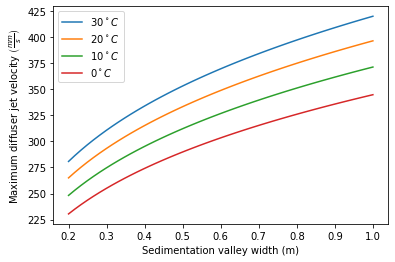

0.0124


In [17]:
tau_max = 0.5529 * u.Pa 

v_z_fb = 1 *u.mm/u.s
W_sed = 1.06 * u.m
W_sed_range = np.linspace(0.2,1,50)*u.m
def v_jet_max(v_z_fb, W_sed,tau_max,temp):
  return (np.sqrt(tau_max / ac.density_water(temp)) * (v_z_fb * W_sed / ac.viscosity_kinematic_water(temp) / ac.con.JET_PLANE_RATIO)**(1/4)).to(u.mm/u.s)

jetHL = v_jet_max(v_z_fb, W_sed,tau_max,temp)**2/(2 * u.gravity)
print(jetHL.to(u.cm))
plt.plot(W_sed_range,v_jet_max(v_z_fb,W_sed_range,tau_max,30*u.degC));
plt.plot(W_sed_range,v_jet_max(v_z_fb,W_sed_range,tau_max,20*u.degC));
plt.plot(W_sed_range,v_jet_max(v_z_fb,W_sed_range,tau_max,10*u.degC));
plt.plot(W_sed_range,v_jet_max(v_z_fb,W_sed_range,tau_max,0.1*u.degC));
plt.xlabel('Sedimentation valley width (m)');
plt.ylabel(r'Maximum diffuser jet velocity $\left(\frac{mm}{s}\right)$');
plt.legend(['$30^\circ C$','$20^\circ C$','$10^\circ C$','$0^\circ C$']);
plt.show()

print(ac.con.JET_PLANE_RATIO)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return array(a, dtype, copy=False, order=order)


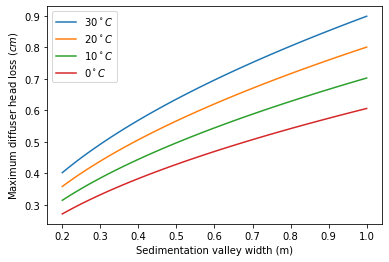

In [7]:
plt.plot(W_sed_range,(v_jet_max(v_z_fb,W_sed_range,tau_max,30*u.degC)**2 / (2 * u.gravity)).to(u.cm));
plt.plot(W_sed_range,(v_jet_max(v_z_fb,W_sed_range,tau_max,20*u.degC)**2 / (2 * u.gravity)).to(u.cm));
plt.plot(W_sed_range,(v_jet_max(v_z_fb,W_sed_range,tau_max,10*u.degC)**2 / (2 * u.gravity)).to(u.cm));
plt.plot(W_sed_range,(v_jet_max(v_z_fb,W_sed_range,tau_max,0.1*u.degC)**2 / (2 * u.gravity)).to(u.cm));
plt.xlabel('Sedimentation valley width (m)');
plt.ylabel(r'Maximum diffuser head loss $\left(cm\right)$');
plt.legend(['$30^\circ C$','$20^\circ C$','$10^\circ C$','$0^\circ C$']);
plt.show()

Now we can find the maximum manifold velocity
$$\frac{\bar v_{P}}{\bar v_{M_1}} = \sqrt{\frac{\Pi_{Q}^2 + 1}{2(1 - \Pi_{Q}^2)}}$$

$$\frac{\bar v_{M_1}}{\bar v_{P}} = \sqrt{\frac{2(1 - \Pi_{Q}^2)}{\Pi_{Q}^2 + 1}}$$

Find length of a sed tank served by an 8" manifold



Given the velocity in the manifolds, could we minimize the plastic given a dimension for the sed tank? 

In [8]:
Pi_Q = 0.85
Pi_v = np.sqrt(2 * (1-Pi_Q**2)/(Pi_Q**2+1))
print(Pi_v)



0.5676320073700932


$$\frac{\bar v_{M_1}^{2}}{2 g} = 2\bar \Psi_{M}\frac{1 - \Pi_{Q}^2}{\Pi_{Q}^2 + 1}$$

#Plate Settler Length in short tanks
The plate settler length must accommodate the lost triangle at the end of the sed tank.

$$\bar v_{z_{Plate}} L_{active}= \bar v_{z_{Sed}} L_{sed}$$
$$L_{active} = L_{sed} - L_{inactive}$$
$$L_{inactive} = L_{plate} cos(\alpha)$$

Now solve for the active vertical velocity

$$\frac{\bar v_{z_{Plate}}}{\bar v_{z_{Sed}}} =  \frac{ L_{sed}}{L_{sed} - L_{plate} cos(\alpha)}$$

bring $\bar v_c$ into the equation for similarity with capture velocity equation.

$$\frac{\bar v_{z_{Plate}}}{\bar v_c} = \frac{\bar v_{z_{Sed}}}{\bar v_c} \frac{  L_{sed}}{L_{sed} - L_{plate} cos(\alpha)}$$

From [equation](https://aguaclara.github.io/Textbook/Sedimentation/Sed_Derivations.html#equation-sedimentation-sed-derivations-8) in the AguaClara textbook
$$L_{plate} = \frac{S\left(\frac{\bar v_{z_{Plate}}}{\bar v_c}-1\right) + T\left(\frac{\bar v_{z_{Plate}}}{\bar v_c}\right)}{sin(\alpha) cos(\alpha)}$$

Now we have two equations in two unknowns ($\frac{\bar v_{z_{Plate}}}{\bar v_c}$ and $L_{plate}$). First rearrange the equation for $L_{plate}$.

$$L_{plate}sin(\alpha) cos(\alpha) = \frac{S\bar v_{z_{Plate}}}{\bar v_c}-S + \frac{T\bar v_{z_{Plate}}}{\bar v_c}$$

$$L_{plate}\frac{sin(\alpha) cos(\alpha)}{S+T}+\frac{S}{S+T} = \frac{\bar v_{z_{Plate}}}{\bar v_c} $$

Substitute equation for $\frac{\bar v_{z_{Plate}}}{\bar v_c}$

$$L_{plate}\frac{sin(\alpha) cos(\alpha)}{S+T}+\frac{S}{S+T} = \frac{\bar v_{z_{Sed}}}{\bar v_c} \frac{ L_{sed}}{L_{sed} - L_{plate} cos(\alpha)} $$

$$\left(L_{sed} - L_{plate} cos(\alpha)\right)\left(L_{plate}\frac{sin(\alpha) cos(\alpha)}{S+T}+\frac{S}{S+T}\right) = L_{sed}\frac{\bar v_{z_{Sed}}}{\bar v_c}  $$

$$L_{sed} \left(L_{plate}\frac{sin(\alpha) cos(\alpha)}{S+T}+\frac{S}{S+T}\right) -L_{plate} cos(\alpha) \left(L_{plate}\frac{sin(\alpha) cos(\alpha)}{S+T}+\frac{S}{S+T}\right) - L_{sed}\frac{\bar v_{z_{Sed}}}{\bar v_c} =0 $$

$$ L_{plate}\frac{L_{sed}sin(\alpha) cos(\alpha)}{S+T} + -L_{plate}L_{plate} cos(\alpha)\frac{sin(\alpha) cos(\alpha)}{S+T}-\frac{S L_{plate} cos(\alpha)}{S+T} +\frac{L_{sed}S}{S+T} - L_{sed}\frac{\bar v_{z_{Sed}}}{\bar v_c} =0 $$

done to here

$$ -L_{plate}^2 sin(\alpha) cos^2(\alpha) + L_{plate}L_{sed}sin(\alpha) cos(\alpha) - S L_{plate} cos(\alpha) + L_{sed}S - L_{sed}\frac{\bar v_{z_{Sed}}}{\bar v_c}(S+T)=0 $$

more simplification

$$ L_{plate}^2 sin(\alpha) cos^2(\alpha) +  L_{plate} \left[S cos(\alpha)- L_{sed}sin(\alpha) cos(\alpha)\right]  + L_{sed}\left(\frac{\bar v_{z_{Sed}}}{\bar v_c}(S+T)-S\right)=0 $$


In [9]:
flocHopperQ = 12 * u.mL/u.s
flocHopperD = pipe.ID_sch40(3*u.inch)
temp = 20 * u.degC
Nu = ac.viscosity_kinematic_water(temp)
flocHopperRe = ac.re_pipe(flocHopperQ,flocHopperD,Nu)
print("The Reynolds number for the floc hopper flow is",flocHopperRe)


The Reynolds number for the floc hopper flow is 195.4 dimensionless


The Reynolds number doesn't take into account the fact that there is significant return flow back to the sed tank. I am not clear on how the two flows will interact and the potential for eddy formation at the interface between the two currents. According to [Barmaka et al. (2016)](https://arxiv.org/ftp/arxiv/papers/1605/1605.05095.pdf) flow instabilities are caused by shear at the interface between the countercurrent flows. To solve this problem we should design a manifold to collect the clarified water so that the return flow is in a separate space. This will eliminate the shear at the interface. The challenge will be designing a manifold that only picks up the clarifed water.

We can turn a sloped pipe into a mini sedimentation tank with sludge flowing by gravity to the end of the pipe and clear water collected in a manifold along the sloped top of the pipe. 

What diameter of pipe is required to collect the return flow? We should analyze both dilute and concentrated floc blankets that occur for low and high turbidity respectively.

$$\rho_{fb} = \left( 1 - \frac{\rho_{H_2O}}{\rho_{clay}} \right)C_{clay} + \rho_{H_2O}$$ [textbook](https://aguaclara.github.io/Textbook/Sedimentation/Sed_Derivations.html#equation-sedimentation-sed-derivations-61)

$$ \Delta \rho_{fb} = \rho_{fb} - \rho_{H_2O}$$

$$ \Delta \rho_{fb} = \left( 1 - \frac{\rho_{H_2O}}{\rho_{clay}} \right)C_{clay}$$

The head loss through the outlet manifold is set by the density of the incoming floc blanket. Consolidation could potentially help increase this density. 

$$ H = L sin(\theta)$$

$$\Delta P = \Delta \rho_{fb} g H$$

$$HL = \frac{\Delta P}{\rho_{H_2O} g} $$

$$HL = \frac{\Delta \rho_{fb} H}{\rho_{H_2O}}$$

$$HL = L sin(\theta)\left( \frac{1}{\rho_{H_2O}} - \frac{1}{\rho_{clay}} \right)C_{clay}$$

This is a manifold and thus the head loss in the manifold is 1/3 the head loss of a constant flow pipe. Thus we can design the manifold for 3 times the available head loss.

The available head is also used to deliver the water into the floc hopper. Thus we should design the manifold for 1.5 times the available head loss.

The minimum floc hopper cross sectional area is double the manifold area.

In [10]:
waterRHO = ac.density_water(temp)
clayC = 3 * u.NTU
flocNetC = 100 * u.NTU
Q = 5 * u.L/u.s
flocNetRHO = (1 - waterRHO / ac.Clay.Density) * clayC + waterRHO
L = 1 * u.m
tubeAN = 60 * u.deg
HL = L * np.sin(tubeAN) * (1/waterRHO - 1/ac.Clay.Density) * clayC
flocHopperQ = Q * clayC/flocNetC
KMinor = 2
manifoldIDmin = ac.diam_pipe(flocHopperQ,HL*1.5,L,Nu,ac.PVC_PIPE_ROUGH,KMinor)
print("the manifold ID is",manifoldIDmin.to(u.cm),"for a flow of",flocHopperQ.to(u.mL/u.s))
flocHopperIDmin = np.sqrt(2*(manifoldIDmin**2))
print("The floc hopper ID min is",flocHopperIDmin)


the manifold ID is 18.67 centimeter for a flow of 150 milliliter / second
The floc hopper ID min is 0.264 meter


The worst situation for getting the return flow back out of the floc hopper is when the floc blanket is most dilute and lowest density. High turbidity results in a more concentrated flocnet and that significantly increases the available energy to move the return flow back out of the floc hopper and that more than compensates for the higher flow required. 

# Floc Hopper Settler Design
The flocs should settle at the upflow velocity. To give a factor of safety, perhaps use a capture velocity of 1/2 the upflow velocity.

Find the required length of the sedimentation area in the floc hopper given the diameter. We will only use the area provided by the bottom half of the pipe as sedimentation area with no plate inserts.

$$ settlerL = \frac{projectedPlateA}{hopperID cos(tubeAN)}$$



In [11]:
hopperCaptureV = 0.5 * u.mm/u.s
projectedPlateA = (flocHopperQ/hopperCaptureV).to(u.m**2)
print("The required projected plate area is ",projectedPlateA)
settlerL = projectedPlateA/(flocHopperIDmin * np.cos(tubeAN))
print("The minimum length of the floc hopper for sedimentation is",settlerL)

The required projected plate area is  0.3 meter ** 2
The minimum length of the floc hopper for sedimentation is 2.273 meter


# Manifold Design Considerations

The openings into the manifold should be as high as possible. The manifold should discharge well above the flocnet interface to reduce the flocs that fall into the effluent manifold. The manifold exit should be protected from flocs falling from the plate settlers. The discharge from the manifold should be deflected horizontally so that the discharge has no vertical momentum that would propel it through the floc blanket. It may be ideal to have the discharge of the manifold directed downward for improved energy dissipation of the jet.

The bottom end of the manifold should be some distance from the end of the floc hopper so there is place for floc consolidation. The lower end of the manifold should be open or closed? 

If the lower end of the manifold is closed then it won't be possible for any flocs that settle inside the manifold to leave at the bottom. If it is open there may be a risk of the floc suspension moving up into the manifold. This requires analysis of the equilibrium floc/water interface using pressure. TBD 